# Final project

João Nogueira A87973

Miguel Gonçalves A90416


## Desenvolver uma expressão 3-Sat


In [2]:
import numpy as np
from qiskit import Aer
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import PhaseOracle
from math import sqrt, ceil, floor, pi

In [3]:
#Expressao 3-Sat
satProblem = "3sat.dinamics"
with open(satProblem, 'r') as f:
    sat_cnf = f.read()
print(sat_cnf)

c example DIMACS-CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0


O ficheiro anteriormente apresentado representa o seguinte fórmula 3SAT: 

$f(v_1,v_2,v_3) = (\neg v_1 \lor \neg v_2 \lor \neg v_3) \land (v_1 \lor \neg v_2 \lor v_3) \land (v_1 \lor v_2 \lor \neg v_3) \land (v_1 \lor \neg v_2 \lor \neg v_3) \land (\neg v_1 \lor v_2 \lor v_3) $

Vamos entao usar o PhaseOracle para criar um circuito a partir do ficheiro: 

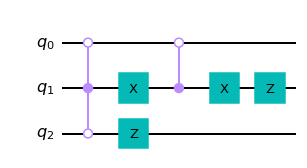

In [4]:
sat_oracle = PhaseOracle.from_dimacs_file("3sat.dinamics")
sat_oracle.draw()

In [5]:
def diffusion_operator(qr):
    qc = QuantumCircuit(qr)
    
    # Apply transformation |s> -> |00..0> (H-gates)
    qc.h(qr)
    
    # Apply transformation |00..0> -> |11..1> (X-gates)
    qc.x(qr)

    
    # Do multi-controlled-Z gate
    qc.h(qr[-1])
    qc.mct(qr[:-1], qr[-1])  # multi-controlled-toffoli
    qc.h(qr[-1])
    
    # Apply transformation |11..1> -> |00..0>

    qc.x(qr)
    
    # Apply transformation |00..0> -> |s>

    qc.h(qr)

    return qc

In [23]:
from math import sqrt, ceil, floor, pi
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute

#Soluções possiveis
possiveis = ['001','010','100','110','011','101','111','000']

    
def count_solutions(oracle_circ):
    #Conta o numero de soluçoes que satisfazem
    k = 0
    for bstr in possiveis:
        if sat_oracle.evaluate_bitstring(bstr[::-1]):
            k += 1

    return k

def alg_Groveer(oracle_circ, iterations = 2):
    nqubits = oracle_circ.num_qubits

    qr = QuantumRegister(nqubits, 'q')
    cr = ClassicalRegister(nqubits, 'c')

    qc = QuantumCircuit(qr, cr)

    qc.h(qr)

    k = count_solutions(oracle_circ)
    N = 2**nqubits

    sqrtN = floor(sqrt(N/k))

    iterations=sqrtN
    for j in range(iterations):
        qc = qc.compose(oracle_circ)
        qc.barrier()
        qc = qc.compose(diffusion_operator(qr))

    qc.measure(qr, cr)
    return qc

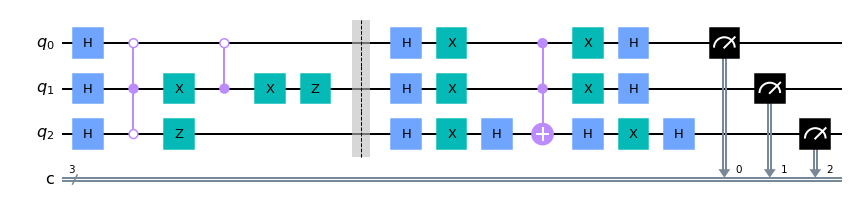

In [24]:
qc = alg_Groveer(sat_oracle)
qc.draw(output="mpl")

Para simular e obter os resultados em gráfico fizemos a seguinte função: 

In [25]:
from qiskit.compiler import transpile

def execute_circuit_2(qc, shots=1024, decimal=False):
    #define backend
    device = Aer.get_backend('qasm_simulator')

    #get counts
    qc_transpiled = transpile(qc, backend=device)
    counts = device.run(qc_transpiled, shots=shots).result().get_counts()

    if decimal:
        counts = dict((int(a[::-1],2),b) for (a,b) in counts.items())
    else:
        counts = dict((a[::-1],b) for (a,b) in counts.items())

    return counts

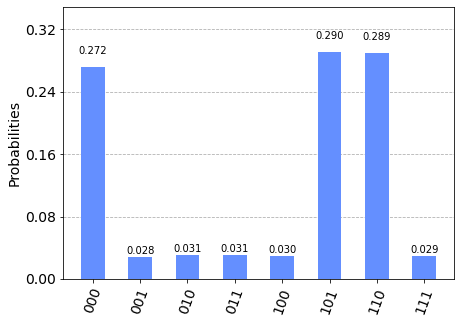

In [31]:
counts = execute_circuit_2(qc, shots = 4096)
plot_histogram(counts)

In [28]:
count_solutions(sat_oracle)

3

Pela análise do gráfico, as soluções mais prováveis são 000, 101 e 110, as quais estão claramente corretas.

Assim, o nosso algoritmo de Groover consegue encontrar soluções fiáveis para expressões 3-Sat.

# Analise da complexidade: 

## Computação clássica

1. Caso médio

    Dadas N soluções possíveis para o nosso 3SAT problema, em média iria ter de se verificar N/2 dessas soluções
    Ou seja, $\mathcal{O}(N)$

2. Pior caso

    No piro caso iria ter de se verificar todas as soluções possiveis, neste caso N
    
## Computação quântica

Num computador quântico conseguimos encontrar a solução em $\sqrt{N/K}$ passos com o algoritmo de Groover.

Este algoritmo não usa listas, o que o torna um algoritmo genérico. Deste modo ele devolve imediatamente uma melhoria quadrática para tantos problemas clássicos.

Assim, $\mathcal{O}(\sqrt{N/K})$


## Conclusões 

É claro que uma melhoria quadrática no tempo em que se encontra uma solução é bastante considerável.


